Sept 9, 2023: finetuning my own adapter using llama_index code

In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.logger import logger

## 1. Load base embedding model; use Helper fns for adapter model, loss, optimizer
- For the adapter, we use a linear model created using the nn.Module class.  There are 3 functions (get_config_dict, save and load) that is less typically, but allows one to save the adapter for later use.
- The loss function also uses the nn.Module class, which allows a simpler application of the adapter.  However, this could be done in alternative methods.

In [2]:
from llama_index.embeddings import resolve_embed_model
from src.adapter import LinearModel, LossFunction, optimizer
embed_model = resolve_embed_model("local:BAAI/bge-small-en")
adapter = LinearModel(embed_model=embed_model)
device='cpu'
#device='mps'
loss_function = LossFunction(model=adapter, device=device)
opt = optimizer(model=adapter, lr=1e-3)

## 2. Create a Dataset and a DataLoader
This is done in the fairly standard way.  The only step to note is that the collate function converts the text into embeddings using the embedding model, so the partial function is needed.

In [3]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset
from torch.utils.data import DataLoader
from src.adapter import data_to_dataset, collate_fn
from functools import partial

In [4]:
data = EmbeddingQAFinetuneDataset.from_json("../data/train_dataset.json")
data_validate = EmbeddingQAFinetuneDataset.from_json("../data/val_dataset.json")
dataset = data_to_dataset(data)
dataset_validate = data_to_dataset(data_validate)
collate_fn_ = partial(collate_fn, embed_model=embed_model)
data_loader = DataLoader(dataset, batch_size=32, collate_fn=collate_fn_, shuffle=True)
data_loader_validate = DataLoader(dataset_validate, batch_size=32, collate_fn=collate_fn_, shuffle=False)

2023-09-17 13:04:10,338 - src.logger - INFO - **MSP: Number of examples: 198
2023-09-17 13:04:10,339 - src.logger - INFO - **MSP: Number of examples: 204


## 3. Set up parameters for Training

In [5]:
adapter.to(device)
loss_function.to(device)
epochs = 8
steps_per_epoch = len(data_loader)
num_train_steps = int(epochs * steps_per_epoch)
logger.info(f'Number of steps per epoch: {steps_per_epoch}')
logger.info(f'Number of training steps: {num_train_steps}')

2023-09-17 13:04:10,398 - src.logger - INFO - Number of steps per epoch: 7
2023-09-17 13:04:10,399 - src.logger - INFO - Number of training steps: 56


## 4. Training Loop

In [6]:
from tqdm.autonotebook import trange
from llama_index.bridge.langchain import print_text

global_step = 0
lst_train_loss = []
lst_val_loss = []
lst_train_acc = []
lst_val_acc = []
lst_train_top2 = []
lst_val_top2 = []

for epoch in trange(epochs, desc="Epoch"):

    loss_function.zero_grad()
    loss_function.train()
    data_iterator = iter(data_loader)
    for query, context in data_iterator:


        loss_value = loss_function(query, context)
        loss_value.backward()
        print_text(f"> [Epoch {epoch}] Current loss: {loss_value}\n", color="blue")
        
        opt.step()
        opt.zero_grad()

    loss_function.eval()

    train_loss = sum([loss_function(q,e) for q,e in data_loader])
    val_loss = sum([loss_function(q,e) for q,e in data_loader_validate])
    train_acc = loss_function.accuracy(data_loader)
    val_acc = loss_function.accuracy(data_loader_validate)
    train_top2 = loss_function.topk(data_loader)
    val_top2 = loss_function.topk(data_loader_validate)

    lst_train_loss.append(train_loss.item())
    lst_val_loss.append(val_loss.item())
    lst_train_acc.append(train_acc)
    lst_val_acc.append(val_acc)
    lst_train_top2.append(train_top2)
    lst_val_top2.append(val_top2)

    logger.info(f"Epoch {epoch} train loss: {train_loss:.4f}")
    logger.info(f"Epoch {epoch} val loss: {val_loss:.4f}")
    logger.info(f"Epoch {epoch} train acc: {train_acc:.4f}")
    logger.info(f"Epoch {epoch} val acc: {val_acc:.4f}")
    logger.info(f"Epoch {epoch} train top2: {train_top2:.4f}")
    logger.info(f"Epoch {epoch} val top2: {val_top2:.4f}")

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

> [Epoch 0] Current loss: 2.253431558609009
> [Epoch 0] Current loss: 2.0672128200531006
> [Epoch 0] Current loss: 1.8571759462356567
> [Epoch 0] Current loss: 1.9351911544799805
> [Epoch 0] Current loss: 1.834742784500122
> [Epoch 0] Current loss: 1.692406415939331
> [Epoch 0] Current loss: 1.0663012266159058


2023-09-17 13:08:58,519 - src.logger - INFO - Epoch 0 train loss: 10.2493
2023-09-17 13:08:58,520 - src.logger - INFO - Epoch 0 val loss: 14.1755
2023-09-17 13:08:58,520 - src.logger - INFO - Epoch 0 train acc: 0.7828
2023-09-17 13:08:58,520 - src.logger - INFO - Epoch 0 val acc: 0.4363
2023-09-17 13:08:58,520 - src.logger - INFO - Epoch 0 train top2: 0.8990
2023-09-17 13:08:58,520 - src.logger - INFO - Epoch 0 val top2: 0.7647


> [Epoch 1] Current loss: 1.534096598625183
> [Epoch 1] Current loss: 1.8350330591201782
> [Epoch 1] Current loss: 1.391573190689087
> [Epoch 1] Current loss: 1.4553757905960083
> [Epoch 1] Current loss: 1.370334506034851
> [Epoch 1] Current loss: 1.3472861051559448
> [Epoch 1] Current loss: 0.49824264645576477


2023-09-17 13:12:04,330 - src.logger - INFO - Epoch 1 train loss: 8.2132
2023-09-17 13:12:04,330 - src.logger - INFO - Epoch 1 val loss: 13.4065
2023-09-17 13:12:04,331 - src.logger - INFO - Epoch 1 train acc: 0.8030
2023-09-17 13:12:04,331 - src.logger - INFO - Epoch 1 val acc: 0.4363
2023-09-17 13:12:04,331 - src.logger - INFO - Epoch 1 train top2: 0.9242
2023-09-17 13:12:04,331 - src.logger - INFO - Epoch 1 val top2: 0.7647


> [Epoch 2] Current loss: 1.1350276470184326
> [Epoch 2] Current loss: 1.299754023551941
> [Epoch 2] Current loss: 1.3014869689941406
> [Epoch 2] Current loss: 1.2366515398025513
> [Epoch 2] Current loss: 1.2049376964569092
> [Epoch 2] Current loss: 0.9717578291893005
> [Epoch 2] Current loss: 0.28100889921188354


2023-09-17 13:15:08,444 - src.logger - INFO - Epoch 2 train loss: 6.5618
2023-09-17 13:15:08,444 - src.logger - INFO - Epoch 2 val loss: 12.8465
2023-09-17 13:15:08,444 - src.logger - INFO - Epoch 2 train acc: 0.8485
2023-09-17 13:15:08,445 - src.logger - INFO - Epoch 2 val acc: 0.4314
2023-09-17 13:15:08,445 - src.logger - INFO - Epoch 2 train top2: 0.9596
2023-09-17 13:15:08,445 - src.logger - INFO - Epoch 2 val top2: 0.7647


> [Epoch 3] Current loss: 1.071411371231079
> [Epoch 3] Current loss: 1.0222755670547485
> [Epoch 3] Current loss: 0.9441150426864624
> [Epoch 3] Current loss: 0.9400334358215332
> [Epoch 3] Current loss: 0.9538522362709045
> [Epoch 3] Current loss: 1.1783583164215088
> [Epoch 3] Current loss: 0.2680402100086212


2023-09-17 13:18:16,541 - src.logger - INFO - Epoch 3 train loss: 6.0409
2023-09-17 13:18:16,541 - src.logger - INFO - Epoch 3 val loss: 12.4533
2023-09-17 13:18:16,541 - src.logger - INFO - Epoch 3 train acc: 0.8232
2023-09-17 13:18:16,542 - src.logger - INFO - Epoch 3 val acc: 0.4314
2023-09-17 13:18:16,542 - src.logger - INFO - Epoch 3 train top2: 0.9697
2023-09-17 13:18:16,542 - src.logger - INFO - Epoch 3 val top2: 0.7745


> [Epoch 4] Current loss: 0.8915044665336609
> [Epoch 4] Current loss: 0.8074014782905579
> [Epoch 4] Current loss: 0.8702660202980042
> [Epoch 4] Current loss: 0.9202234745025635
> [Epoch 4] Current loss: 1.1031086444854736
> [Epoch 4] Current loss: 0.8841409683227539
> [Epoch 4] Current loss: 0.2813877463340759


2023-09-17 13:22:27,707 - src.logger - INFO - Epoch 4 train loss: 4.8042
2023-09-17 13:22:27,707 - src.logger - INFO - Epoch 4 val loss: 12.2761
2023-09-17 13:22:27,708 - src.logger - INFO - Epoch 4 train acc: 0.8737
2023-09-17 13:22:27,708 - src.logger - INFO - Epoch 4 val acc: 0.4167
2023-09-17 13:22:27,708 - src.logger - INFO - Epoch 4 train top2: 0.9949
2023-09-17 13:22:27,708 - src.logger - INFO - Epoch 4 val top2: 0.7549


> [Epoch 5] Current loss: 0.8382015228271484
> [Epoch 5] Current loss: 0.8239295482635498
> [Epoch 5] Current loss: 0.6686861515045166
> [Epoch 5] Current loss: 0.846878707408905
> [Epoch 5] Current loss: 0.7772508859634399
> [Epoch 5] Current loss: 0.7429831027984619
> [Epoch 5] Current loss: 0.28968870639801025


2023-09-17 13:26:46,166 - src.logger - INFO - Epoch 5 train loss: 4.2883
2023-09-17 13:26:46,166 - src.logger - INFO - Epoch 5 val loss: 12.1090
2023-09-17 13:26:46,167 - src.logger - INFO - Epoch 5 train acc: 0.8636
2023-09-17 13:26:46,167 - src.logger - INFO - Epoch 5 val acc: 0.4265
2023-09-17 13:26:46,167 - src.logger - INFO - Epoch 5 train top2: 0.9899
2023-09-17 13:26:46,168 - src.logger - INFO - Epoch 5 val top2: 0.7598


> [Epoch 6] Current loss: 0.655660092830658
> [Epoch 6] Current loss: 0.6770262122154236
> [Epoch 6] Current loss: 0.630679190158844
> [Epoch 6] Current loss: 0.6315335631370544
> [Epoch 6] Current loss: 0.6443634033203125
> [Epoch 6] Current loss: 0.5990947484970093
> [Epoch 6] Current loss: 0.19634132087230682


2023-09-17 13:31:30,124 - src.logger - INFO - Epoch 6 train loss: 3.6731
2023-09-17 13:31:30,125 - src.logger - INFO - Epoch 6 val loss: 11.9703
2023-09-17 13:31:30,125 - src.logger - INFO - Epoch 6 train acc: 0.8788
2023-09-17 13:31:30,125 - src.logger - INFO - Epoch 6 val acc: 0.4216
2023-09-17 13:31:30,125 - src.logger - INFO - Epoch 6 train top2: 0.9949
2023-09-17 13:31:30,126 - src.logger - INFO - Epoch 6 val top2: 0.7794


> [Epoch 7] Current loss: 0.6250579953193665
> [Epoch 7] Current loss: 0.6899899244308472
> [Epoch 7] Current loss: 0.6150736212730408
> [Epoch 7] Current loss: 0.6521733403205872
> [Epoch 7] Current loss: 0.6379866003990173
> [Epoch 7] Current loss: 0.6149593591690063
> [Epoch 7] Current loss: 0.030857255682349205


2023-09-17 13:36:17,561 - src.logger - INFO - Epoch 7 train loss: 3.5785
2023-09-17 13:36:17,561 - src.logger - INFO - Epoch 7 val loss: 11.8926
2023-09-17 13:36:17,562 - src.logger - INFO - Epoch 7 train acc: 0.9242
2023-09-17 13:36:17,562 - src.logger - INFO - Epoch 7 val acc: 0.4216
2023-09-17 13:36:17,562 - src.logger - INFO - Epoch 7 train top2: 1.0000
2023-09-17 13:36:17,562 - src.logger - INFO - Epoch 7 val top2: 0.7696


## 5. Performance

In [7]:
import matplotlib.pyplot as plt
x = list(range(1, epochs+1))

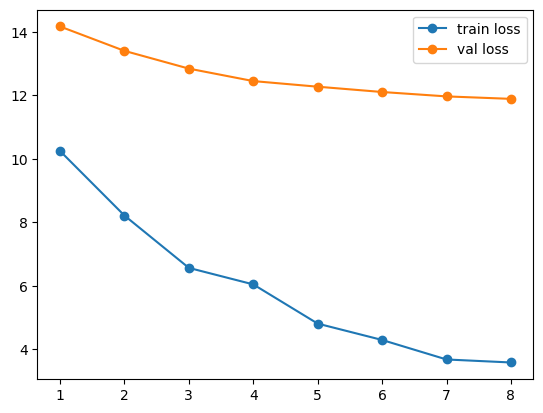

In [8]:
plt.plot(x, lst_train_loss, 'o-', label='train loss')
plt.plot(x, lst_val_loss, 'o-',label='val loss')
plt.legend()
plt.show()

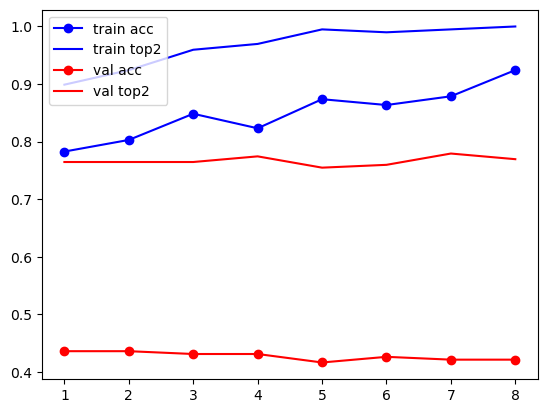

In [9]:
plt.plot(x, lst_train_acc, 'o-', color='blue', label='train acc')
plt.plot(x, lst_train_top2, '-', color='blue', label='train top2')
plt.plot(x, lst_val_acc,  'o-', color='red', label='val acc')
plt.plot(x, lst_val_top2,  '-', color='red', label='val top2')
plt.legend()
plt.show()